In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

pd.set_option('display.max_columns', None)

# <a name="top"></a> US Census Data:
## A Study of Which Features Impact Income Greater or Lesser than $50,000


### Data Cleaning and Engineering


### Project Contents:
|Name|Description|
|---|---|
|1_cleaning_eda|Cleans and prepares data for modeling. Initial EDA.|
|2_modeling|Binary classification model predicting income greater or lesser than $50k.|


You are currently in notebook 1_cleaning_eda. 



#### Notebook Table of Contents

* [Reading in the raw data and initial EDA](#read)
* [Cleaning the US Census Data for Modeling](#clean_census)
* [Exploratory Data Analysis](#eda)


#### Notebook summary: 
The US Census Data provides abundant feature to consider. While initial EDA reveals no nulls in the data, closer examination proves the data to be a bit more complicated to prepare for modeling. 

##### Not in Universe:
* Several questions indicate that a feature is 'Not in universe' -- a designation indicates that this question was not asked of the interviewee. Generally, this appears to be related to questions that would not have been applicable to the interviewee. For example, it would be logical to assume that a person who states that they are currently employed would not be asked about reason for unemployment. 

##### MSA
* MSA = Metropolitan Statistical Area. An MSA consists of one or more counties that contain a city of 50,000 or. more inhabitants, or contain a Census Bureau-defined urbanized area (UA) and have a total population of at least 100,000 (75,000 in New England).

### <a name="read"></a>Reading in the raw data and initial EDA
[Jump to the top of this notebook](#top)

In [44]:
# setting column headers

headers = ['age', 'worker_class', 'industry_detailed','occupation_detailed', 'education', 'wage_per_hour', 'education_current_enrollment','marital_status', 
           'industry_major', 'occupation_major', 'race', 'hispanic_origin', 'sex', 'labor_union','unemployment_reason', 'employment_status', 
           'cap_gains', 'cap_loss', 'stock_dividends', 'tax_filer_stat', 'residence_region', 'residence_state', 'household_detailed', 'household_summary', 'instance_weight',
           'mig_code_change_in_msa', 'mig_code_change_in_reg', 'move_in_region', 'same_res_one_year_ago', 'pre_res_sunbelt','num_employed', 'fam_members_under_18','country_birth_father','country_birth_mother',
           'country_birth_self', 'citizenship', 'self_employed', 'vets_admin_quest', 'veterans_benefits', 'weeks_worked', 'year', 'target']

In [45]:
# reading in the raw US census data, divided into training and testing datasets. 

train_df = pd.read_csv('./data/raw_data/census_income_learn.csv', names=headers, index_col=False)
test_df = pd.read_csv('./data/raw_data/census_income_test.csv', names=headers, index_col=False)

I wanted to pull in world development indicators for country of origin. After further reflection, I'm not sure how useful this information can be without also knowing what a year a person or their parents arrived in the US. I do still think that it is an important item for future examination. This could be an interesting time series investigation, given the right data. 

In [46]:
dev_df = pd.read_excel('./data/raw_data/world_bank_income_rankings_2021.xlsx', sheet_name='List of economies', usecols=['Economy', 'Income group'])
dev_df.head(3)

,Economy,Income group
0,Aruba,High income
1,Afghanistan,Low income
2,Angola,Lower middle income


In [47]:
train_df.shape

(199523, 42)

In [48]:
train_df.head(3)

,age,worker_class,industry_detailed,occupation_detailed,education,wage_per_hour,education_current_enrollment,marital_status,industry_major,occupation_major,race,hispanic_origin,sex,labor_union,unemployment_reason,employment_status,cap_gains,cap_loss,stock_dividends,tax_filer_stat,residence_region,residence_state,household_detailed,household_summary,instance_weight,mig_code_change_in_msa,mig_code_change_in_reg,move_in_region,same_res_one_year_ago,pre_res_sunbelt,num_employed,fam_members_under_18,country_birth_father,country_birth_mother,country_birth_self,citizenship,self_employed,vets_admin_quest,veterans_benefits,weeks_worked,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   age                           199523 non-null  int64  
 1   worker_class                  199523 non-null  object 
 2   industry_detailed             199523 non-null  int64  
 3   occupation_detailed           199523 non-null  int64  
 4   education                     199523 non-null  object 
 5   wage_per_hour                 199523 non-null  int64  
 6   education_current_enrollment  199523 non-null  object 
 7   marital_status                199523 non-null  object 
 8   industry_major                199523 non-null  object 
 9   occupation_major              199523 non-null  object 
 10  race                          199523 non-null  object 
 11  hispanic_origin               199523 non-null  object 
 12  sex                           199523 non-nul

In [50]:
train_df.describe()

,age,industry_detailed,occupation_detailed,wage_per_hour,cap_gains,cap_loss,stock_dividends,instance_weight,num_employed,self_employed,veterans_benefits,weeks_worked,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


In [51]:
train_df.columns

Index(['age', 'worker_class', 'industry_detailed', 'occupation_detailed',
       'education', 'wage_per_hour', 'education_current_enrollment',
       'marital_status', 'industry_major', 'occupation_major', 'race',
       'hispanic_origin', 'sex', 'labor_union', 'unemployment_reason',
       'employment_status', 'cap_gains', 'cap_loss', 'stock_dividends',
       'tax_filer_stat', 'residence_region', 'residence_state',
       'household_detailed', 'household_summary', 'instance_weight',
       'mig_code_change_in_msa', 'mig_code_change_in_reg', 'move_in_region',
       'same_res_one_year_ago', 'pre_res_sunbelt', 'num_employed',
       'fam_members_under_18', 'country_birth_father', 'country_birth_mother',
       'country_birth_self', 'citizenship', 'self_employed',
       'vets_admin_quest', 'veterans_benefits', 'weeks_worked', 'year',
       'target'],
      dtype='object')

In [52]:
column_list = list(train_df.columns)

#uncomment the code below to see value counts for each column. I used this when considering how I wanted to handle categorical variables, but please note that this will print a very long output.

# for col in column_list:
#     print(col + '\n', train_df[col].value_counts(normalize=True), '\n')

In [53]:
train_df['citizenship'].value_counts(normalize=True)

 Native- Born in the United States              0.887076
 Foreign born- Not a citizen of U S             0.067165
 Foreign born- U S citizen by naturalization    0.029345
 Native- Born abroad of American Parent(s)      0.008801
 Native- Born in Puerto Rico or U S Outlying    0.007613
Name: citizenship, dtype: float64

In [54]:
train_df['citizenship'][0]

' Native- Born in the United States'

In [55]:

income_citizenship = train_df.groupby(by = 'target')['citizenship'].value_counts(normalize=True)

In [56]:
income_citizenship

target     citizenship                                 
 - 50000.   Native- Born in the United States              0.886193
            Foreign born- Not a citizen of U S             0.068980
            Foreign born- U S citizen by naturalization    0.028187
            Native- Born abroad of American Parent(s)      0.008699
            Native- Born in Puerto Rico or U S Outlying    0.007941
 50000+.    Native- Born in the United States              0.900420
            Foreign born- U S citizen by naturalization    0.046842
            Foreign born- Not a citizen of U S             0.039735
            Native- Born abroad of American Parent(s)      0.010338
            Native- Born in Puerto Rico or U S Outlying    0.002665
Name: citizenship, dtype: float64

<AxesSubplot:xlabel='count', ylabel='citizenship'>

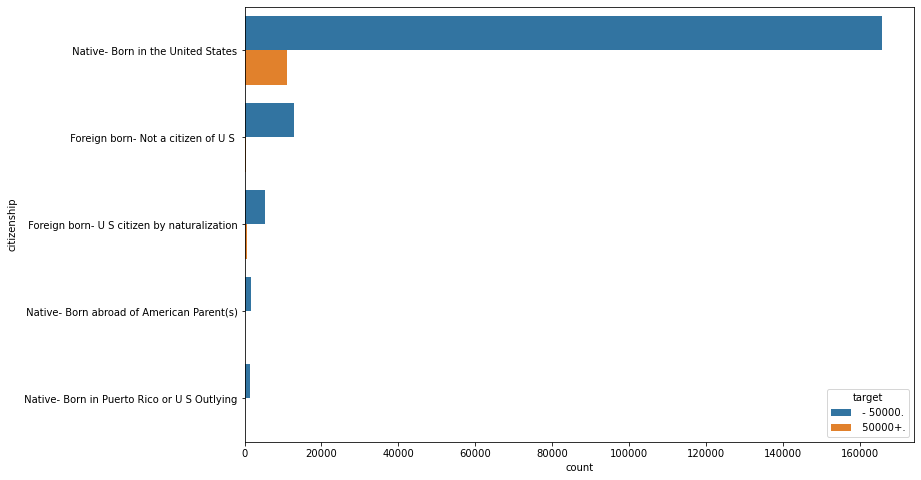

In [57]:
plt.figure(figsize=(12,8))
sns.countplot(y = train_df['citizenship'], hue = train_df['target'])

### <a name="clean_census"></a>Cleaning the US Census Data for Modeling
[Jump to the top of this notebook](#top)

In [58]:
# A function to prepare training and testing dataframes for modeling. 

def prep_for_model(df):
    
    '''
    a function to prepare dataframes for binary classification modeling. 
    converts categorical features to numerical values.
    '''
    
    def parent_birth_country(row):  
        '''
        preparing to engineer new feature designating if a person has 0, 1, or 2 parents born in the US.
        '''
        if row['country_birth_father'] == 0 and row['country_birth_mother'] == 0:
            return 0
        elif row['country_birth_father'] == 1 and row['country_birth_mother'] == 1:
            return 2
        else:
            return 1
    
    def citizenship(row):  
        '''
        preparing to engineer new feature designating if a person was born a US citizen, became a citizen, or is not a citizen.
        '''
        
        born_amcit = [' Native- Born in the United States', ' Native- Born abroad of American Parent(s)', ' Native- Born in Puerto Rico or U S Outlying']
        became_amcit = [' Foreign born- U S citizen by naturalization']
        not_amcit = [' Foreign born- Not a citizen of U S', ]
        if row['citizenship'] in born_amcit:
            return 2
        elif row['citizenship']in became_amcit:
            return 1
        else:
            return 0
    
    #binarize sex (0=male, 1=female)
    df['sex'] = [1 if sex.strip() == 'Female' else 0 for sex in df['sex']]
    
    #binarize birth country father, mother, self
    df['country_birth_father'] = [1 if country.strip() == 'United-States' else 0 for country in df['country_birth_father']]
    df['country_birth_mother'] = [1 if country.strip() == 'United-States' else 0 for country in df['country_birth_mother']]
    df['country_birth_self'] = [1 if country.strip() == 'United-States' else 0 for country in df['country_birth_self']]
    
    #encode categoricals
    features_to_encode = ['worker_class', 'education', 'education_current_enrollment', 'marital_status', 'race', 'hispanic_origin', 'labor_union',
                     'unemployment_reason', 'employment_status', 'tax_filer_stat', 'household_summary', 'same_res_one_year_ago', 
                     'vets_admin_quest', 'industry_major', 'occupation_major']
    for cat in features_to_encode:
        le = LabelEncoder()
        le.fit(df[cat])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print('labelencode map: ', cat)
        print(le_name_mapping)
        print('\n')
        df[cat] = le.transform(df[cat])
        
    #map parents in household for family members under age 18
    fam_members_under_18_map = {' Not in universe': 2, ' Both parents present': 2, ' Mother only present': 1, ' Father only present': 1, ' Neither parent present': 0}
    df['fam_members_under_18'] = df['fam_members_under_18'].map(fam_members_under_18_map)
    
    #get dummies
    df = pd.get_dummies(train_df, columns=['race'], drop_first=True)
     
    #mapping parent_birth_country_function
    df['parent_birth_country'] = df.apply(lambda row: parent_birth_country(row), axis=1)
    
    #mapping citizenship function
    df['citizenship'] = df.apply(lambda row: citizenship(row), axis=1)
    
    #binarize target: 0: -50000 / 1: +50000
    df['target'] = [0 if income ==  ' - 50000.' else 1 for income in df['target']]
    
        
    #drop features from modeling
    df.drop(columns=['instance_weight', 'year', 'household_detailed', 'residence_region', 'residence_state', 'mig_code_change_in_msa',
                    'mig_code_change_in_reg', 'move_in_region', 'pre_res_sunbelt', 'country_birth_mother',
                    'country_birth_father'], inplace=True)
    
    return df
    

In [59]:
#clean training and testing dfs for modeling

model_train_df = prep_for_model(train_df)
model_test_df = prep_for_model(test_df)

#export cleanedtraining and testing dfs as csvs

model_train_df.to_csv('./data/transformed_data/model_train_df.csv', index=False)
model_test_df.to_csv('./data/transformed_data/model_test_df.csv', index=False)

labelencode map:  worker_class
{' Federal government': 0, ' Local government': 1, ' Never worked': 2, ' Not in universe': 3, ' Private': 4, ' Self-employed-incorporated': 5, ' Self-employed-not incorporated': 6, ' State government': 7, ' Without pay': 8}


labelencode map:  education
{' 10th grade': 0, ' 11th grade': 1, ' 12th grade no diploma': 2, ' 1st 2nd 3rd or 4th grade': 3, ' 5th or 6th grade': 4, ' 7th and 8th grade': 5, ' 9th grade': 6, ' Associates degree-academic program': 7, ' Associates degree-occup /vocational': 8, ' Bachelors degree(BA AB BS)': 9, ' Children': 10, ' Doctorate degree(PhD EdD)': 11, ' High school graduate': 12, ' Less than 1st grade': 13, ' Masters degree(MA MS MEng MEd MSW MBA)': 14, ' Prof school degree (MD DDS DVM LLB JD)': 15, ' Some college but no degree': 16}


labelencode map:  education_current_enrollment
{' College or university': 0, ' High school': 1, ' Not in universe': 2}


labelencode map:  marital_status
{' Divorced': 0, ' Married-A F spouse p

### <a name="eda"></a>Exploratory Data Analysis
[Jump to the top of this notebook](#top)

In [60]:
model_train_df.head(3)

,age,worker_class,industry_detailed,occupation_detailed,education,wage_per_hour,education_current_enrollment,marital_status,industry_major,occupation_major,hispanic_origin,sex,labor_union,unemployment_reason,employment_status,cap_gains,cap_loss,stock_dividends,tax_filer_stat,household_summary,same_res_one_year_ago,num_employed,fam_members_under_18,country_birth_self,citizenship,self_employed,vets_admin_quest,veterans_benefits,weeks_worked,target,race_1,race_2,race_3,race_4,parent_birth_country
0,73,3,0,0,12,0,2,6,14,6,0,1,1,3,2,0,0,0,4,6,1,0,2,1,2,0,1,2,0,0,0,0,0,1,2
1,58,6,4,34,16,0,2,0,4,8,0,0,1,3,0,0,0,0,0,4,0,1,2,1,2,0,1,2,52,0,0,0,0,1,2
2,18,3,0,0,0,0,1,4,14,6,0,1,1,3,2,0,0,0,4,0,1,0,2,0,0,0,1,2,0,0,1,0,0,0,0


<AxesSubplot:>

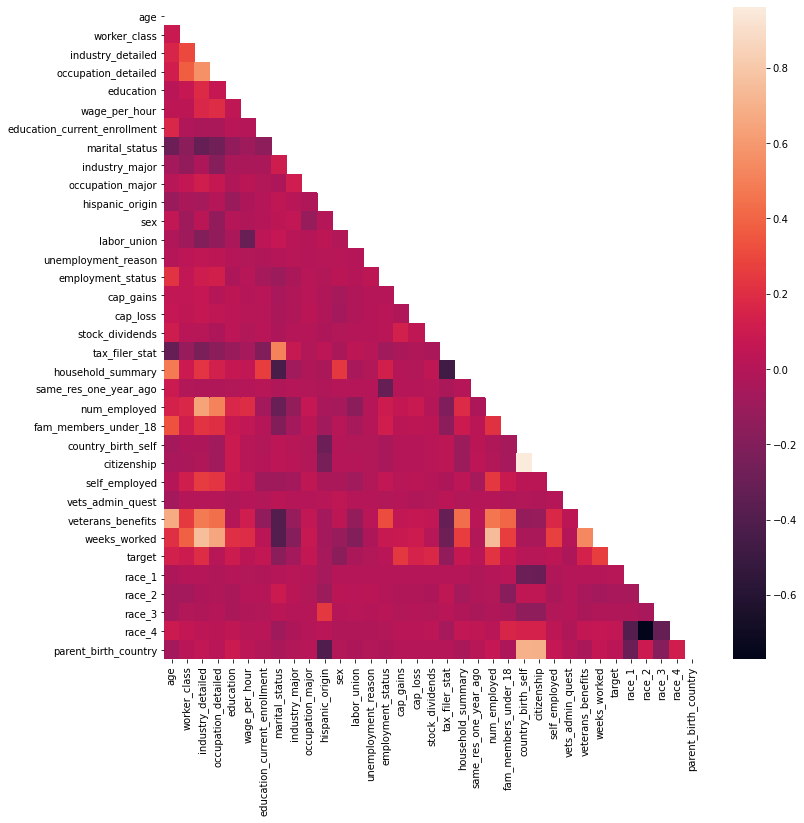

In [322]:
plt.figure(figsize=(12,12))
mask = np.triu(np.ones_like(model_df.corr(), dtype=bool))
sns.heatmap(model_df.corr(), mask=mask)

In [222]:
le = LabelEncoder()
le.fit(train_df['worker_class'])

LabelEncoder()

In [223]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(le_name_mapping)

array([' Federal government', ' Local government', ' Never worked',
       ' Not in universe', ' Private', ' Self-employed-incorporated',
       ' Self-employed-not incorporated', ' State government',
       ' Without pay'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='country_birth_father'>

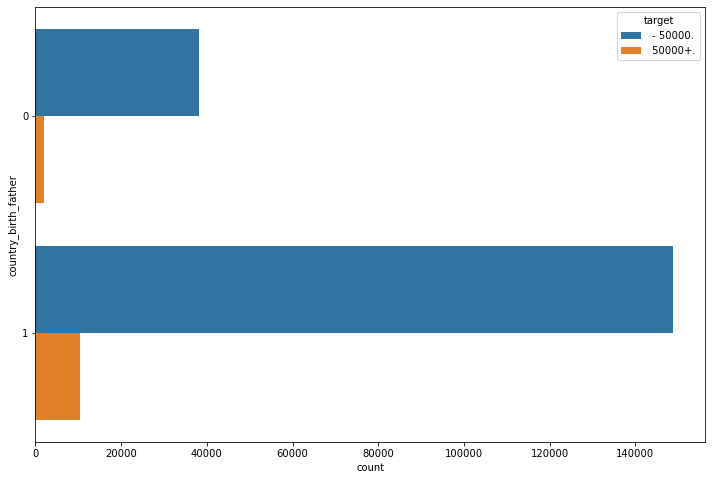

In [263]:
plt.figure(figsize=(12,8))
sns.countplot(y = train_df['country_birth_father'], hue = train_df['target'])

<AxesSubplot:xlabel='count', ylabel='country_birth_self'>

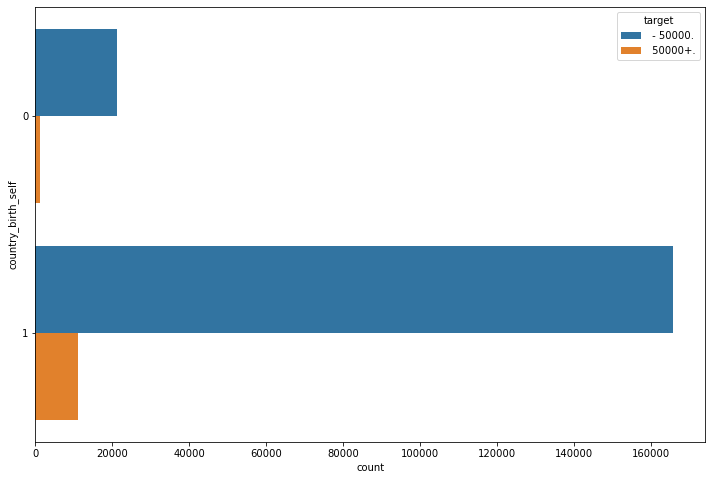

In [264]:
plt.figure(figsize=(12, 8))
sns.countplot(y = train_df['country_birth_self'], hue = train_df['target'])